# Predicting Implied Volatility for Arbitrary Strike Prices

Using polygon.io for index options data.

This will be used for the purposes of gauging probability of a price close within a certain price range or outside of a upper/lower bound given some arbitrary price ranges.

This notebook will explore accuracy of different regression models for this task. Strike-IV does not follow a linear relationship, so various non-linear regression methods will be used.

**Possible Models**

1. **Polynomial Regression**:
    - Given that the relationship between strike prices and implied volatility can often be non-linear (e.g., the volatility smile or skew), polynomial regression can be a good fit.
    - You can start with a quadratic term (second-degree polynomial) and then test higher degrees to see if they provide a better fit. However, be cautious with very high degrees as they can lead to overfitting.

2. **Local Regression (LOESS or LOWESS)**:
    - Local regression is a non-parametric method that fits multiple regressions in localized subsets of the data. This approach can capture varying relationships across different strike prices.
    - The key parameter to adjust is the window or span, which determines how much of the data is used for each local regression.

3. **Splines**:
    - Splines, particularly cubic splines, can be used to create piecewise polynomial fits to the data. This is a flexible method that can fit complex relationships between strike and implied volatility.
    - To avoid overfitting, you might use penalized splines or "smoothing splines."

4. **Neural Networks**:
    - Given enough data, a simple feedforward neural network can capture the non-linear relationship between strike prices and implied volatility. However, it's essential to ensure you don't overfit the data by having too complex a network for the amount of data you have.

5. **Gaussian Processes**:
    - Gaussian Processes (GPs) provide a non-parametric Bayesian approach to regression. GPs can give you both a mean function (the predicted IV for a given strike) and a variance function (the uncertainty in the prediction).
    - GPs can be computationally intensive for large datasets, but they're very flexible.

6. **Random Forests or Gradient Boosted Trees**:
    - Tree-based methods can capture non-linear relationships and interactions. Given that they're based on decision trees, they can handle non-linear patterns in the data efficiently.

## Gathering options data

In [24]:
# imports
from polygon import RESTClient
POLYGON_API_KEY = None
from datetime import datetime
import matplotlib.pyplot as plt

In [25]:
# docs
# https://polygon.io/docs/options/get_v3_snapshot_options__underlyingasset___optioncontract
# https://polygon-api-client.readthedocs.io/en/latest/Snapshot.html

# client = RESTClient("XXXXXX") # hardcoded api_key is used
client = RESTClient(api_key=POLYGON_API_KEY)  # POLYGON_API_KEY environment variable is used

In [48]:
# Get options chain

underlying = "SPX"
today = datetime.today().strftime("%Y-%m-%d")
today = "2023-08-25"

snapshot = client.get_snapshot_option("I:SPX", "O:SPXW230823P04500000")

# print raw values
print(snapshot)

OptionContractSnapshot(break_even_price=None, day=DayOptionContractSnapshot(change=-45.6, change_percent=-41.6, close=64, high=88.85, last_updated=1692748800000000000, low=58.32, open=88.85, previous_close=109.6, volume=62, vwap=64.1281), details=OptionDetails(contract_type='put', exercise_style='european', expiration_date='2023-08-23', shares_per_contract=100, strike_price=4500, ticker='O:SPXW230823P04500000'), greeks=Greeks(delta=-0.97098324879596, gamma=0.0020016185852167654, theta=-5.070881935035424, vega=0.053229221668127685), implied_volatility=0.32510152771791734, last_quote=LastQuoteOptionContractSnapshot(ask=63.4, ask_size=5, bid=62.8, bid_size=21, last_updated=1692818291703374848, midpoint=63.1, timeframe='REAL-TIME'), last_trade=LastTradeOptionContractSnapshot(price=64, sip_timestamp=1692818083759279616, size=1, conditions=[209], exchange=302, timeframe='REAL-TIME'), open_interest=1249, underlying_asset=UnderlyingAsset(change_to_break_even=None, last_updated=1680814651655000

In [49]:
def build_options_data(underlying, today):

    data = {'call': [], 'put': []}

    for c in client.list_snapshot_options_chain(underlying_asset=underlying, params={"expiration_date": today}):
        if c.greeks.delta == None or c.implied_volatility == None:
            continue
        data[c.details.contract_type].append({'ticker': c.details.ticker, 'iv': c.implied_volatility, 'delta': c.greeks.delta, 'expiration_date': c.details.expiration_date, 'strike_price': c.details.strike_price})
    
    return data

data = build_options_data(underlying="I:SPX", today=today)

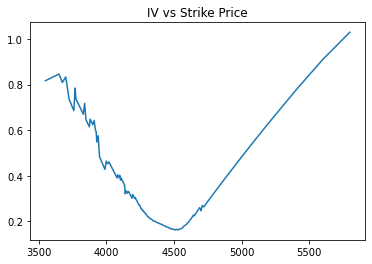

In [50]:
# Plotting
strikes = [x['strike_price'] for x in data['call']]
ivs = [x['iv'] for x in data['call']]
plt.plot(strikes, ivs)
plt.title("IV vs Strike Price")
plt.show()

## Polynomial Regression

In [51]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [52]:
# init data
X = np.array(strikes).reshape(-1, 1)
y = ivs

# partition
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
# train

degree = 4  # nonlinear, expect degree should be roughly between 3-6

# Transform data to polynomial features
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Fit the model
regressor = LinearRegression()
regressor.fit(X_poly, y_train)

LinearRegression()

Mean Squared Error: 0.0004491934213798966
Root Mean Squared Error: 0.021194183668636464


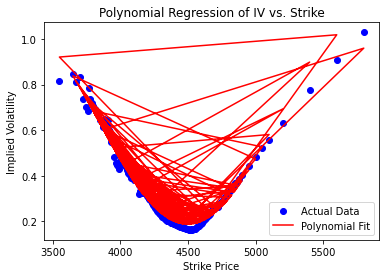

In [54]:
# evaluate

# Predict on test set
y_pred = regressor.predict(X_poly_test)

# Calculate and print MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")

# Plot the results
plt.scatter(X_train, y_train, color='blue', label='Actual Data')
plt.plot(X_train, regressor.predict(X_poly), color='red', label='Polynomial Fit')
plt.title('Polynomial Regression of IV vs. Strike')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

In [55]:
def predict_iv(strike_value):
    strike_transformed = poly.transform(np.array(strike_value).reshape(-1, 1))
    return regressor.predict(strike_transformed)[0]

# Example usage:
strike_value = 4500
predicted_iv = predict_iv(strike_value)
print(f"Predicted IV for strike {strike_value}: {predicted_iv}")
snapshot = client.get_snapshot_option("I:SPX", "O:SPXW230823P04500000")
print(f"Actual IV for strike {strike_value}: {snapshot.implied_volatility}")

Predicted IV for strike 4500: 0.18767845019579
Actual IV for strike 4500: 0.24952252766919314


**Conclusions**

Predictions are disappointingly shit nearest to the money due to increasing nonlinearity when you approach ATM options. Although this model will primarily be used for further OTM strikes (bidirectionally), it would be nice to find a model that is both accurate near the money and OTM.

It is possible that the polynomial regression above will be the best one we explore for OTM strikes. It is unlikely that another model is unable to make a substantial and consistent improvement on the above for near the money strikes. We may need to resort to discrimination of models used depending on expected moneyness prediction range.

I predict that piecewise regression may be best for what I want here as it will (as I understand) allow us to model piecewise relationships between the strikes and effectively offer higher weights to these abnormally non-linear strike-iv relationships NTM.

_________

## Piecewise Polynomial Regression

In [59]:
# data

strikes = np.array([x['strike_price'] for x in data['call']])
ivs = np.array([x['iv'] for x in data['call']])

In [70]:
# Define the 'near-the-money' region
at_the_money_strike = 4450  # i would assume arg_strike for min iv?
bandwidth = int(at_the_money_strike * .05)  # 5% around atm

near_the_money_mask = np.abs(strikes - at_the_money_strike) < bandwidth
X_near = strikes[near_the_money_mask].reshape(-1, 1)
y_near = ivs[near_the_money_mask]

X_other = strikes[~near_the_money_mask].reshape(-1, 1)
y_other = ivs[~near_the_money_mask]

In [71]:
# Define polynomial degree for each region
degree_near = 4

# Fit polynomial regression for near-the-money data
poly_near = PolynomialFeatures(degree=degree_near)
X_poly_near = poly_near.fit_transform(X_near)
regressor_near = LinearRegression().fit(X_poly_near, y_near)

In [72]:
degree_other = 4

# Fit polynomial regression for other data
poly_other = PolynomialFeatures(degree=degree_other)
X_poly_other = poly_other.fit_transform(X_other)
regressor_other = LinearRegression().fit(X_poly_other, y_other)

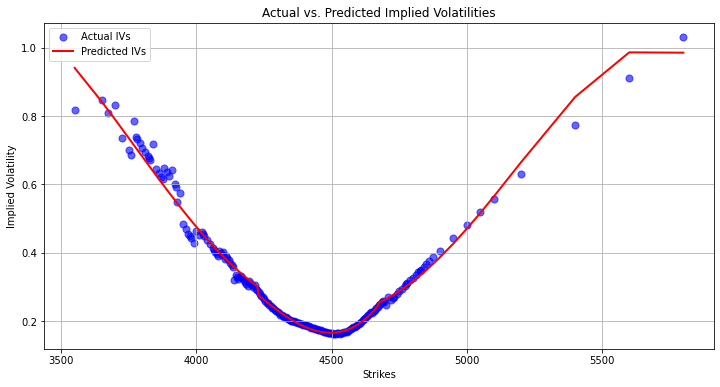

In [73]:
# Prediction function
def predict_iv(strike):
    if np.abs(strike - at_the_money_strike) < bandwidth:
        x_poly = poly_near.transform([[strike]])
        return regressor_near.predict(x_poly)[0]
    else:
        x_poly = poly_other.transform([[strike]])
        return regressor_other.predict(x_poly)[0]

# Predict across all strikes
predicted_ivs = [predict_iv(strike) for strike in strikes]

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(strikes, ivs, color='blue', label='Actual IVs', s=50, alpha=0.6)
plt.plot(strikes, predicted_ivs, color='red', label='Predicted IVs', linewidth=2)
plt.xlabel('Strikes')
plt.ylabel('Implied Volatility')
plt.title('Actual vs. Predicted Implied Volatilities')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
# Predictions for near-the-money and other data
predicted_ivs_near = regressor_near.predict(poly_near.transform(X_near))
predicted_ivs_other = regressor_other.predict(poly_other.transform(X_other))

# Calculate MSE for both regions
mse_near = mean_squared_error(y_near, predicted_ivs_near)
mse_other = mean_squared_error(y_other, predicted_ivs_other)

# Calculate overall MSE
predicted_ivs_all = np.concatenate((predicted_ivs_near, predicted_ivs_other))
y_all = np.concatenate((y_near, y_other))
mse_overall = mean_squared_error(y_all, predicted_ivs_all)

print(f"MSE for Near-the-money model: {mse_near}")
print(f"MSE for Other model: {mse_other}")
print(f"Overall MSE: {mse_overall}")

MSE for Near-the-money model: 1.5904063982234884e-05
MSE for Other model: 0.0008871043237470188
Overall MSE: 0.0004994202081516899


# W

**Conclusions**

Significant improvement with pw polynomial regression. In a prod environment, unless someone with more expertise can suggest me a static degree for near and distant IV prediction models, we may want to employ a ML based approach to degree selection based on various environmental conditions either as a daily model warm up or a continuously updated variable in shmem with another model using it as the target variable to predict algo returns or MSE or whatever.